In [1]:
from google.colab import files
uploaded = files.upload()

Saving VNMacroQuater_2014_2024.xlsx to VNMacroQuater_2014_2024.xlsx


In [2]:
from google.colab import files
uploaded = files.upload()

Saving DATA_LIQUIDITYRISK.xlsx to DATA_LIQUIDITYRISK.xlsx


In [3]:
import pandas as pd
import numpy as np
import re

excel_path = "DATA_LIQUIDITYRISK.xlsx"

# 1) Đọc file
try:
    df = pd.read_excel(excel_path, sheet_name="Data")
except Exception:
    df = pd.read_excel(excel_path)

# 2) Chuẩn hoá tiêu đề (gom khoảng trắng, bỏ xuống dòng)
def norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).replace("\n", " ").strip())
df.columns = [norm(c) for c in df.columns]

# 3) Ánh xạ tên cột sang schema
rename_map = {
    "Mã": "bank_id",
    "Năm": "year",
    "Quý": "quarter",

    # Vi mô cốt lõi
    "BANK SIZE ln(Tổng tài sản)": "ln_TA",
    "ETA Vốn chủ sỡ hữu/Tổng tài sản": "ETA",
    "ROE Lợi nhuận sau thuế/Vốn chủ sở hữu bình quân": "ROE",
    "Nợ xấu (3-5)/ Tổng dư nợ Chỉ số TTM": "NPL_TTM",

    # Thanh khoản mức
    "LTA Dư nợ cho vay/ Tổng tài sản Chỉ số TTM": "LTA",
    "DTA Tiền gửi khách hàng/ Tổng tài sản Chỉ số TTM": "DTA",
    "LTL Tài sản thanh khoản/ Tổng tài sản": "LATA",  # buffer thanh khoản
    # "LTD Tài sản thanh khoản/ Tổng tiền gửi": "LA_Dep_Ratio",
    # "Tài sản thanh khoản/Tổng cho vay": "LA_Loans",
}
df = df.rename(columns=rename_map)

# 5) Cột cần cho merge macro & gắn nhãn
keep_cols = [
    "bank_id", "year", "quarter",
    "ln_TA", "LATA", "ETA", "ROE", "NPL_TTM",
    "LTA", "DTA"  # giữ lại để tạo LA_proxy và Y_stress_t1
]
df_out = df[[c for c in keep_cols if c in df.columns]].copy()

# 6) Xuất file chuẩn hoá
df_out.to_csv("panel_with_micro.csv", index=False, encoding="utf-8-sig")
print("Saved panel_with_micro.csv:", df_out.shape)
print("Columns:", list(df_out.columns))

Saved panel_with_micro.csv: (1188, 10)
Columns: ['bank_id', 'year', 'quarter', 'ln_TA', 'LATA', 'ETA', 'ROE', 'NPL_TTM', 'LTA', 'DTA']


In [4]:
# MACRO
import pandas as pd
import numpy as np
import re

# 1) Đọc file
excel_path = "VNMacroQuater_2014_2024.xlsx"
try:
    macro = pd.read_excel(excel_path, sheet_name="Data")
except Exception:
    macro = pd.read_excel(excel_path)

# 2) Chuẩn hoá tên cột: bỏ xuống dòng, chuẩn khoảng trắng
macro.columns = [re.sub(r"\s+", " ", str(c).replace("\n", " ").strip()) for c in macro.columns]

# 3) Ánh xạ tên cột Macro → schema
rename_map = {}
for c in macro.columns:
    lc = c.lower()
    if lc in {"năm", "nam", "year"}:
        rename_map[c] = "year"
    elif lc in {"quý", "quy", "quarter", "q"}:
        rename_map[c] = "quarter"
    elif "inf" in lc or "cpi" in lc:
        rename_map[c] = "cpi_infl_pct"
    elif "gpd" in lc or "gdp" in lc:
        rename_map[c] = "gdp_growth_pct"
    elif "credit" in lc:
        rename_map[c] = "credit_pct_gdp"
macro = macro.rename(columns=rename_map)

# 4) Chuẩn hoá kiểu số cho 3 cột vĩ mô
def parse_vn_percent(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace("%", "")
    s = re.sub(r"[^\d,.\-]", "", s)
    if s.count(",") > 0 and s.count(".") == 0:
        s = s.replace(",", ".")
    else:
        s = s.replace(",", "")
    try:
        return float(s)
    except:
        return np.nan

for col in ["cpi_infl_pct", "gdp_growth_pct", "credit_pct_gdp"]:
    if col in macro.columns:
        macro[col] = macro[col].apply(parse_vn_percent)

# 5) Chuẩn 'year' & 'quarter', sort theo thời gian
def to_quarter_num(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+)", str(x))
    return int(m.group(1)) if m else np.nan

if "year" in macro.columns:
    macro["year"] = pd.to_numeric(macro["year"], errors="coerce").astype("Int64")
if "quarter" in macro.columns:
    macro["quarter"] = macro["quarter"].apply(to_quarter_num).astype("Int64")

macro = macro.sort_values(["year", "quarter"], na_position="last").reset_index(drop=True)

out_path = "VNMacroQuater_with_lag0.csv"
macro.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Macro (lag0) saved:", macro.shape, "| Columns:", list(macro.columns))

Macro (lag0) saved: (44, 5) | Columns: ['year', 'quarter', 'cpi_infl_pct', 'gdp_growth_pct', 'credit_pct_gdp']


In [20]:
# MERGE
import pandas as pd
import numpy as np

# ---- Khai báo file ----
MICRO_FILE  = "panel_with_micro.csv"
MACRO_FILE  = "VNMacroQuater_with_lag0.csv"
OUTPUT_FILE = "panel_merged.csv"

# ---- 1) Đọc dữ liệu đã chuẩn hóa ----
df_micro = pd.read_csv(MICRO_FILE)
df_macro = pd.read_csv(MACRO_FILE)

# ---- 2) Chuẩn cột khóa ----
for df in (df_micro, df_macro):
    for c in ["year", "quarter"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

macro_cols = ["year","quarter",
              "cpi_infl_pct","gdp_growth_pct","credit_pct_gdp"]
df_macro = df_macro[[c for c in macro_cols if c in df_macro.columns]].copy()

# ---- 3) Merge m:1 theo (year, quarter) | left để giữ toàn bộ micro ----
df_merged = pd.merge(
    df_micro,
    df_macro,
    on=["year","quarter"],
    how="left",
    validate="m:1"
)

# ---- 4) Lưu & log ----
df_merged.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")
print(f"[MERGE] Saved -> {OUTPUT_FILE} | shape={df_merged.shape}")
print("Columns merged-in:", [c for c in macro_cols if c not in ("year","quarter")])


[MERGE] Saved -> panel_merged.csv | shape=(1188, 13)
Columns merged-in: ['cpi_infl_pct', 'gdp_growth_pct', 'credit_pct_gdp']


In [21]:
# LABEL
import pandas as pd
import numpy as np

INPUT_PATH  = "panel_merged.csv"
OUTPUT_PATH = "panel_final_labeled.csv"
ID_KEYS = ["bank_id", "year", "quarter"]
TARGET  = "Y_stress_t1"

# 1) Đọc & chuẩn hoá kiểu
df = pd.read_csv(INPUT_PATH).copy()
df["bank_id"] = df["bank_id"].astype(str)
for c in ["year","quarter"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
df = df.sort_values(ID_KEYS, kind="mergesort").reset_index(drop=True)

# 2) Tính LA_proxy_t = LTA - DTA
missing_core = [c for c in ["LTA","DTA"] if c not in df.columns]
if missing_core:
    raise KeyError(f"Thiếu cột để gắn nhãn: {missing_core}")
df["LA_proxy"] = df["LTA"] - df["DTA"]

# 3) stress_t = 1[LA_proxy_t > 0] (nếu thiếu LTA/DTA → NaN)
df["stress_t"] = np.where(df["LA_proxy"].notna(),
                          (df["LA_proxy"] > 0).astype("Int64"),
                          pd.NA)

# 4) Nhãn dự báo t+1: Y = stress_{t+1} (shift -1 theo bank)
df[TARGET] = (
    df.groupby("bank_id", group_keys=False)["stress_t"]
      .apply(lambda s: s.shift(-1))
)

# 5) Drop hàng không có nhãn (quý cuối mỗi bank hoặc thiếu LTA/DTA ở t+1)
n_before = len(df)
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = df[TARGET].astype(int)
n_after = len(df)

# 6) Lưu & log
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
prev = float(df[TARGET].mean()) if len(df) else float("nan")
print(f"[LABEL] Saved -> {OUTPUT_PATH} | rows={n_after:,} (dropped {n_before-n_after:,}) | prevalence={prev:.3f}")

# 7) Kiểm tra
cols_show = [c for c in [
    "bank_id","year","quarter",
    "LTA","DTA","LA_proxy","stress_t",TARGET,"LATA","ln_TA","ETA","ROE","NPL_TTM",
    "credit_pct_gdp","gdp_growth_pct","cpi_infl_pct"
] if c in df.columns]
print(df[cols_show].head(8))

[LABEL] Saved -> panel_final_labeled.csv | rows=1,020 (dropped 168) | prevalence=0.293
   bank_id  year  quarter     LTA     DTA  LA_proxy stress_t  Y_stress_t1  \
0      ABB  2014        1  0.4430  0.6965   -0.2535        0            0   
1      ABB  2014        2  0.4039  0.6503   -0.2464        0            0   
2      ABB  2014        3  0.3875  0.7010   -0.3135        0            0   
6      ABB  2015        3     NaN     NaN       NaN     <NA>            0   
7      ABB  2015        4  0.4743  0.7383   -0.2640        0            0   
8      ABB  2016        1  0.5159  0.7280   -0.2121        0            0   
10     ABB  2016        3     NaN     NaN       NaN     <NA>            0   
13     ABB  2017        2     NaN     NaN       NaN     <NA>            0   

      LATA    ln_TA     ETA     ROE  NPL_TTM  credit_pct_gdp  gdp_growth_pct  \
0   0.3768  31.5619  0.1143  0.0148   0.0000           11.80            4.96   
1   0.4439  31.7167  0.0959  0.0063   0.0768           11.4

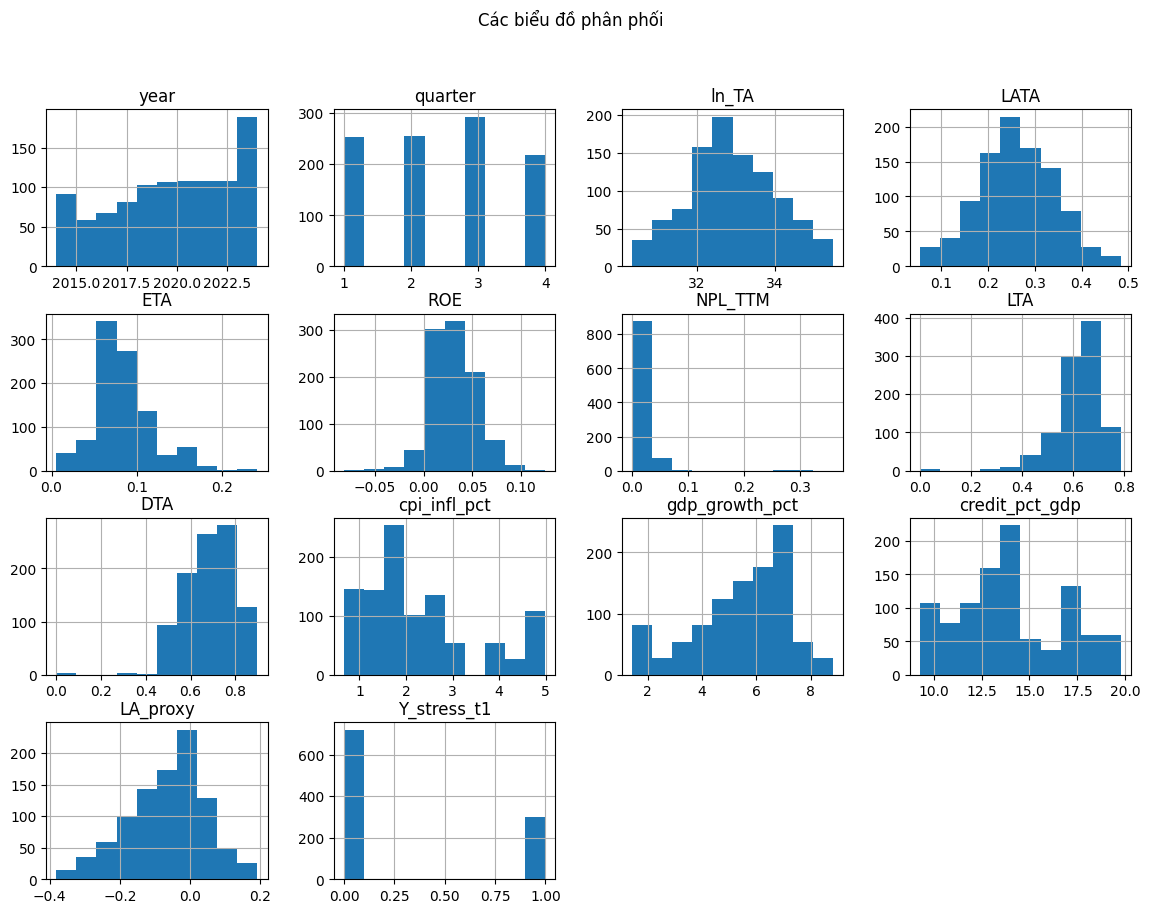

In [22]:
# Xem phân phối biến
import matplotlib.pyplot as plt

df.hist(layout = (4, 4), figsize = (14, 10))
plt.suptitle('Các biểu đồ phân phối')
plt.show()


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1020 entries, 0 to 1186
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bank_id         1020 non-null   object 
 1   year            1020 non-null   Int64  
 2   quarter         1020 non-null   Int64  
 3   ln_TA           991 non-null    float64
 4   LATA            970 non-null    float64
 5   ETA             970 non-null    float64
 6   ROE             965 non-null    float64
 7   NPL_TTM         967 non-null    float64
 8   LTA             967 non-null    float64
 9   DTA             967 non-null    float64
 10  cpi_infl_pct    1020 non-null   float64
 11  gdp_growth_pct  1020 non-null   float64
 12  credit_pct_gdp  1020 non-null   float64
 13  LA_proxy        967 non-null    float64
 14  stress_t        967 non-null    object 
 15  Y_stress_t1     1020 non-null   int64  
dtypes: Int64(2), float64(11), int64(1), object(2)
memory usage: 137.5+ KB


In [35]:
# SPLIT • IMPUTE (median theo bank_id, fit TRAIN) • SCALE (fit TRAIN)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- KHAI BÁO BIẾN (ĐÃ SỬA THEO PHƯƠNG ÁN CUỐI) ---
INPUT_PATH = "panel_labeled_roe_neg.csv"   # File nhãn ROE < 0
TARGET = "Y_stress_roe_neg"                # Biến nhãn
ID_KEYS = ["bank_id", "year", "quarter"]

# 0️⃣ Đọc & chuẩn hóa
df = pd.read_csv(INPUT_PATH).copy()
df["bank_id"] = df["bank_id"].astype(str)
for c in ["year", "quarter"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
df = df.sort_values(ID_KEYS, kind="mergesort").reset_index(drop=True)

# 1️⃣ CHỌN FEATURE (giữ LTA, DTA; bỏ LDR, LATA)
FEATS_COMMON = [
    "ln_TA", "ETA",
    "LTA", "DTA", "NPL_TTM",
    # Biến vĩ mô (lag 1 quý)
    "credit_pct_gdp", "gdp_growth_pct", "cpi_infl_pct"
]

missing = [f for f in FEATS_COMMON if f not in df.columns]
if missing:
    raise KeyError(f"⚠️ Thiếu cột trong panel để train: {missing}")

# 2️⃣ Split theo thời gian (Train <= 2022, Test >= 2023)
train_df = df[df["year"] <= 2022].copy()
test_df  = df[df["year"] >= 2023].copy()
print(f"[SPLIT] train={len(train_df):,} | test={len(test_df):,} | features={len(FEATS_COMMON)}")

# 3️⃣ Impute median theo bank_id (fit TRAIN, áp cho cả TRAIN & TEST)
def impute_by_bank(tr, te, cols, id_col="bank_id"):
    tr = tr.copy(); te = te.copy()
    med_bank = tr.groupby(id_col)[cols].median()
    med_all  = tr[cols].median()
    def fill_block(block):
        bid = block.name
        base = med_bank.loc[bid] if bid in med_bank.index else med_all
        return block[cols].fillna(base)
    tr[cols] = tr.groupby(id_col, group_keys=False).apply(fill_block)
    tr = tr.fillna(med_all)
    te[cols] = te.groupby(id_col, group_keys=False).apply(fill_block)
    te = te.fillna(med_all)
    return tr, te

train_imp, test_imp = impute_by_bank(train_df, test_df, FEATS_COMMON, id_col="bank_id")

miss_tr = int(train_imp[FEATS_COMMON].isna().sum().sum())
miss_te = int(test_imp[FEATS_COMMON].isna().sum().sum())
print(f"[IMPUTE] missing after impute: train={miss_tr} | test={miss_te}")

# 4️⃣ Chuẩn hóa (StandardScaler) — fit trên TRAIN, transform cả TRAIN/TEST
scaler = StandardScaler().fit(train_imp[FEATS_COMMON])
X_tr = pd.DataFrame(scaler.transform(train_imp[FEATS_COMMON]),
                    columns=FEATS_COMMON, index=train_imp.index)
X_te = pd.DataFrame(scaler.transform(test_imp[FEATS_COMMON]),
                    columns=FEATS_COMMON, index=test_imp.index)

# Nhãn Y
y_tr = train_imp[TARGET].astype(int).copy()
y_te = test_imp[TARGET].astype(int).copy()

print(f"[SCALE] X_tr={X_tr.shape} | X_te={X_te.shape}")
print(f"[PREV]  train={y_tr.mean():.3f} | test={y_te.mean():.3f}")

print("\n✅ HOÀN TẤT TIỀN XỬ LÝ (Split, Impute, Scale)")
print("   => Đã tạo X_tr, y_tr, X_te, y_te (đã bỏ LDR, giữ LTA & DTA).")

# Hiển thị 5 dòng đầu của tập train sau chuẩn hóa
print("\n🔎 5 dòng đầu của X_tr:")
display(X_tr.head())


FileNotFoundError: [Errno 2] No such file or directory: 'panel_labeled_roe_neg.csv'

In [26]:
# FEATURE
assert all(v in globals() for v in ["X_tr","X_te","y_tr","y_te"]), \
    "Thiếu X_tr, y_tr, X_te, y_te. Hãy chạy cell SPLIT/IMPUTE/SCALE trước."

FEATS_COMMON = [
    "DTA",
    "LATA",         # Liquid assets / Total assets (buffer)
    "ln_TA",        # Bank size
    "ETA", "ROE", "NPL_TTM",
    "credit_pct_gdp", "gdp_growth_pct", "cpi_infl_pct"
]

missing = [f for f in FEATS_COMMON if f not in X_tr.columns]
if missing:
    raise KeyError(f"Các cột sau không có trong X_tr: {missing}")

print(f"[FEATS_COMMON = {len(FEATS_COMMON)} biến] {FEATS_COMMON}")


[FEATS_COMMON = 9 biến] ['DTA', 'LATA', 'ln_TA', 'ETA', 'ROE', 'NPL_TTM', 'credit_pct_gdp', 'gdp_growth_pct', 'cpi_infl_pct']


MODELS
1. LOGISTIC REGRESSION
2. RF
3. XGB

In [27]:
!pip install -q shap

In [28]:
import xgboost as xgb

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score
)

from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.inspection import PartialDependenceDisplay


1. **XGB section**

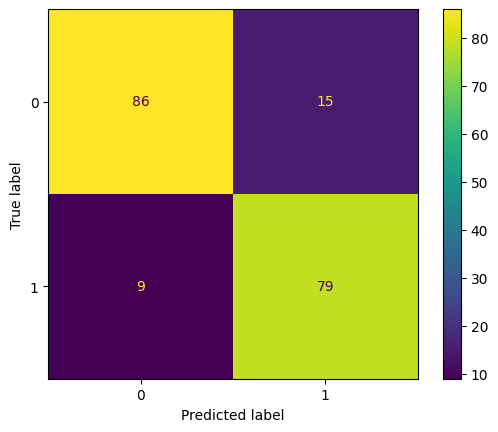

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       101
           1       0.84      0.90      0.87        88

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.88      0.87      0.87       189



In [29]:
xgb_clf = xgb.XGBClassifier(
    # objective = 'binary:logistic',
    # max_delta_step = 8,
    # n_estimators = 600,
    # learning_rate = 0.40,
    # max_depth = 850,
    # max_leaves = 300,
    # reg_lambda = 1.5,
    # reg_alpha = 1.2,
    # grow_policy = "lossguide", # depthwise, lossguide
    # tree_method = 'hist', # 'exact', 'approx'
    # max_bin = 500,
    # booster = 'gbtree',
    # importance_type = 'cover', # “gain”, “weight”, “cover”, “total_gain” or “total_cover”
    # eval_metric = f1_score,
    # scale_pos_weight = 0.5
)
xgb_clf = xgb_clf.fit(X_tr, y_tr)

predict_te = xgb_clf.predict(X_te)

cm = confusion_matrix(y_te, predict_te)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

classification_report_value = classification_report(y_true= y_te, y_pred=predict_te)
print(classification_report_value)

In [31]:
# using SHAP
xgb_explainer = shap.TreeExplainer(xgb_clf)
xgb_shap_values = xgb_explainer.shap_values(X_te)

shap.summary_plot(xgb_shap_values, X_te, feature_names=X_te.columns.tolist())

ValueError: could not convert string to float: '[2.5391096E-1]'

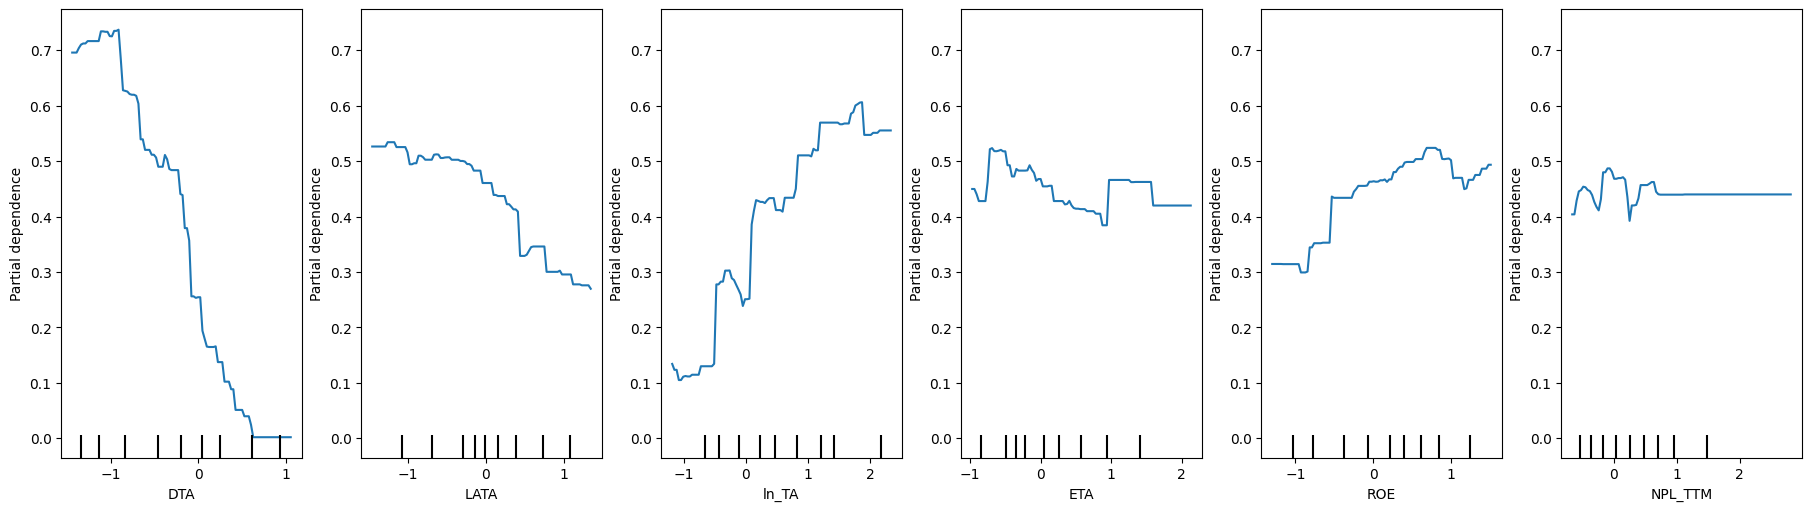

In [32]:
# DPD plot

# feature index select to calculate, according to index of feacture in `X_te`
feature_index = [0,1,2,3,4, 5]

_, ax = plt.subplots(ncols= len(feature_index), nrows=1, figsize=(18, 5), constrained_layout=True)

PartialDependenceDisplay.from_estimator(xgb_clf, X_te, features=feature_index, ax= ax)

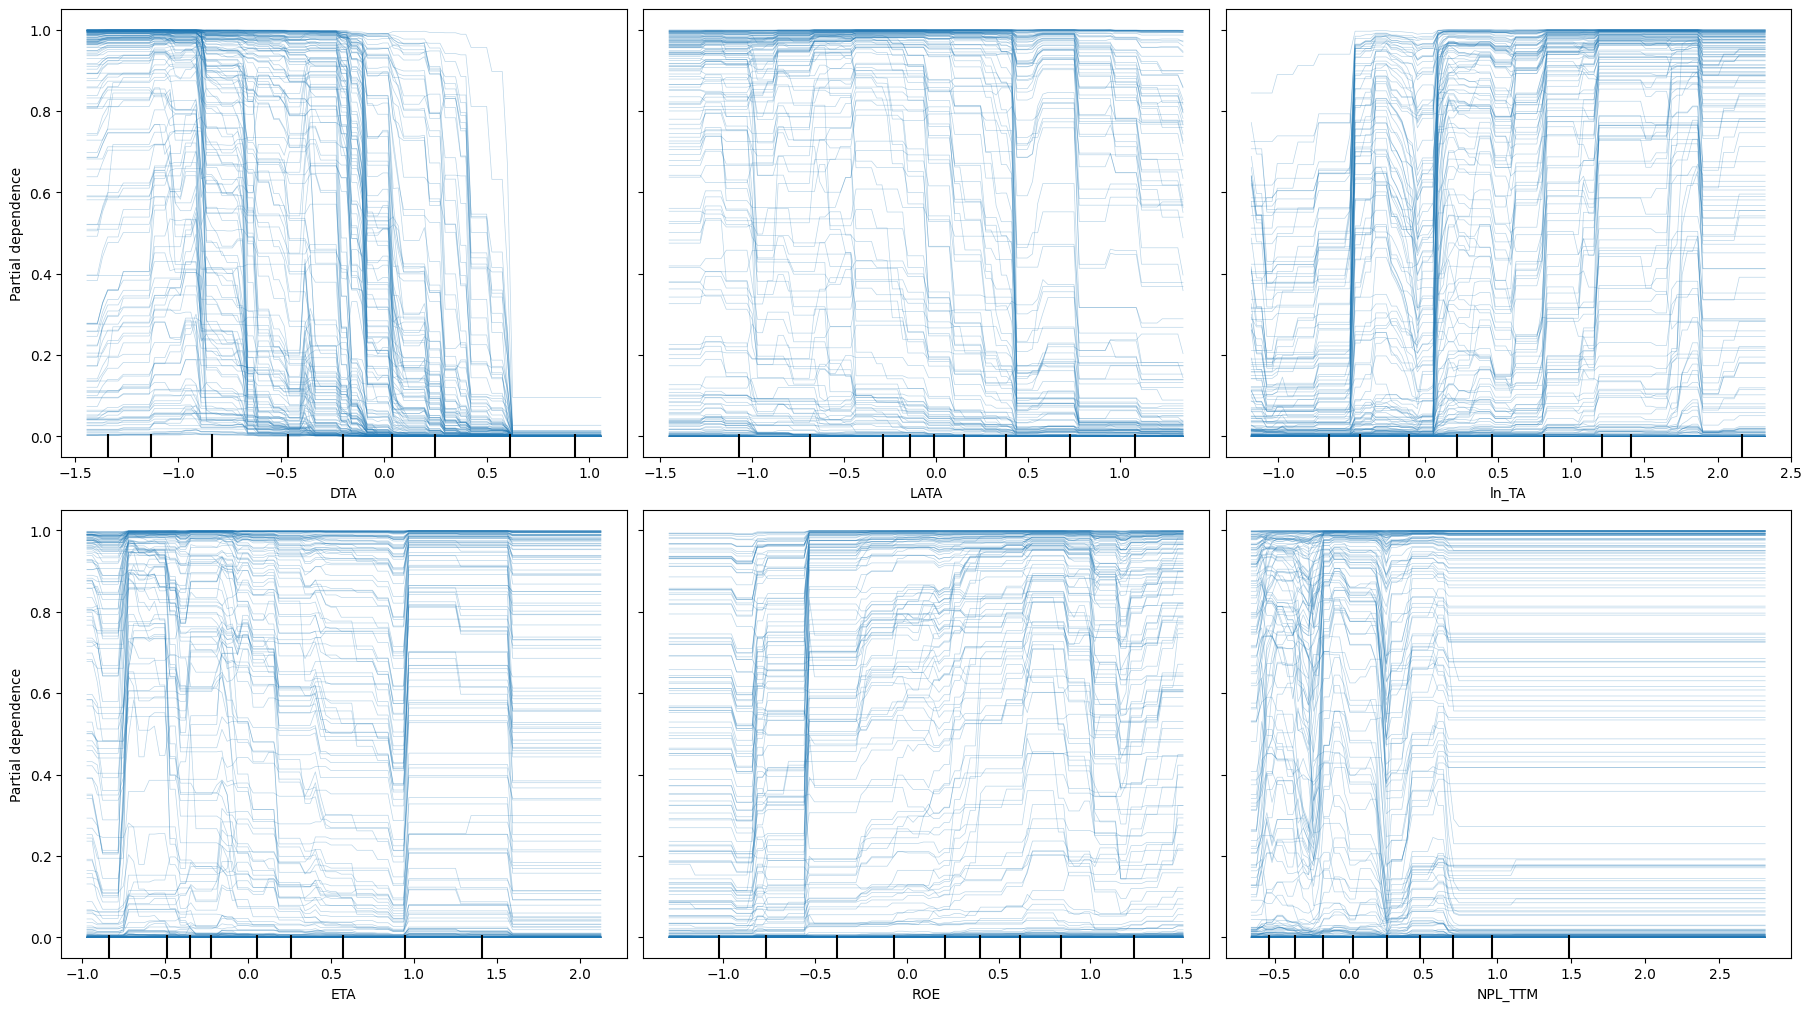

In [33]:
# ICE plot
_, ax = plt.subplots(ncols= 3, nrows=2, figsize=(18, 10), constrained_layout=True)

PartialDependenceDisplay.from_estimator(xgb_clf, X_te, features=feature_index, ax= ax, kind='individual')

2. **Random Forest section**

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_tr, y_tr)

predict_te = rf_clf.predict(X_te)

cm = confusion_matrix(y_te, predict_te)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

classification_report_value = classification_report(y_true= y_te, y_pred=predict_te)
print(classification_report_value)

In [ ]:
# using SHAP
rf_explainer = shap.TreeExplainer(rf_clf)
rf_shap_values = rf_explainer.shap_values(X_te)

shap.summary_plot(rf_shap_values, X_te, feature_names=X_te.columns.tolist(), plot_size=(5,15))

In [ ]:
# DPD plot

# feature index select to calculate, according to index of feacture in `X_te`
feature_index = [0,1,2,3,4, 5]

_, ax = plt.subplots(ncols= len(feature_index), nrows=1, figsize=(18, 5), constrained_layout=True)

PartialDependenceDisplay.from_estimator(rf_clf, X_te, features=feature_index, ax= ax)

In [ ]:
# ICE plot
_, ax = plt.subplots(ncols= 3, nrows=2, figsize=(18, 10), constrained_layout=True)

PartialDependenceDisplay.from_estimator(rf_clf, X_te, features=feature_index, ax= ax, kind='individual')